<a href="https://colab.research.google.com/github/Agamemnommom/Churn-Prediction-Service/blob/notebooks/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, r2_score, classification_report
)


from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

import shap



In [2]:

df = pd.read_csv("/content/customer_churn_dataset-training-master.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
df['Gender'].value_counts()

,count
Gender,
Male,250252
Female,190580


In [5]:
df.describe()


,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [6]:
df.drop(columns='CustomerID', inplace=True)

In [7]:
df

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.00,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.00,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.00,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.00,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.00,20.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
440828,42.0,Male,54.0,15.0,1.0,3.0,Premium,Annual,716.38,8.0,0.0
440829,25.0,Female,8.0,13.0,1.0,20.0,Premium,Annual,745.38,2.0,0.0
440830,26.0,Male,35.0,27.0,1.0,5.0,Standard,Quarterly,977.31,9.0,0.0
440831,28.0,Male,55.0,14.0,2.0,0.0,Standard,Quarterly,602.55,2.0,0.0


In [8]:
#Рассмотрим пропущенные значения:
df.isnull().sum()

,0
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1
Last Interaction,1


In [9]:
df[df.isna().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Уберём эту единственную строчку:
df.dropna(inplace=True)

In [11]:
df.columns

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction', 'Churn'],
      dtype='object')

In [12]:
#Заметим, что все данные имеют тип float, хотя по сути своей почти все целочислены. Исправим это
some_set = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay',
       'Last Interaction', 'Churn']
for word in some_set:
  df[word] = df[word].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  int64  
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  int64  
 3   Usage Frequency    440832 non-null  int64  
 4   Support Calls      440832 non-null  int64  
 5   Payment Delay      440832 non-null  int64  
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  int64  
 10  Churn              440832 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 40.4+ MB


In [13]:
#Функции для визуализации однофакторного анализа

def make_histogram(df, target_feature, bins = 10, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    plt.hist(df[target_feature], bins=bins)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.ylabel('Количество')
    plt.xlabel(target_feature)
    plt.title(f"Распределение {target_feature.lower()}{additional}:\n")
    plt.grid()
    plt.show()
    print(
    f"Распределение {target_feature.lower()}{additional}: "
    f"{df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\n"
    f"Медиана: {df[target_feature].median():.2f} {unit}\n"
    f"Минимум: {df[target_feature].min()} {unit}\n"
    f"Максимум: {df[target_feature].max()} {unit}\n"
    f"{df[target_feature].skew():.3f} Ассиметрия(выброс)\n"
    )

def make_piechart(df, target_feature, additional=''):
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())

    palette_color = sns.color_palette('bright')
    plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
    plt.title(f"Распределение клиентов {target_feature}:")
    plt.show()
    print_str = f"Распределение клиентов {target_feature.lower()}{additional}:"
    for k, v in zip(keys, data):
        print_str += f"\n{v} {k}"
    print(print_str)

def make_barplot(df, target_feature, custom_ticks=None, unit='', additional=''):
    plt.figure(figsize=(10, 5))
    dict_of_val_counts = dict(df[target_feature].value_counts())
    data = list(dict_of_val_counts.values())
    keys = list(dict_of_val_counts.keys())
    plt.bar(keys, data)
    if custom_ticks is not None:
        plt.xticks(custom_ticks)
    plt.xlabel(f'{target_feature.capitalize()}{additional}')
    plt.ylabel('Частота')
    plt.title(f"Распределение клиентов {target_feature.lower()}{additional}\n")
    plt.grid(axis='y')
    plt.show()
    print(f"Распеределение клиентов {target_feature.lower()}{additional}: {df[target_feature].mean():.2f} ± {df[target_feature].median():.2f} {unit}\nMedian: {df[target_feature].median():.2f} {unit}\nMinimum: {df[target_feature].min()} {unit}\nMaximum: {df[target_feature].max()} {unit}\n\n{df[target_feature].skew():.3f} Skewness\n")

def make_boxplot(df, feature):
    plt.figure(figsize=(10,5))
    sns.boxplot(df, x=feature)
    plt.title(f"Boxplot: {feature}\n")
    plt.xlabel(feature)
    plt.ylabel("Значения")
    plt.show()

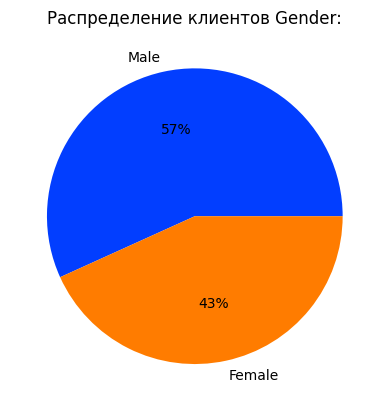

Распределение клиентов gender:
250252 Male
190580 Female


In [14]:
make_piechart(df, 'Gender')

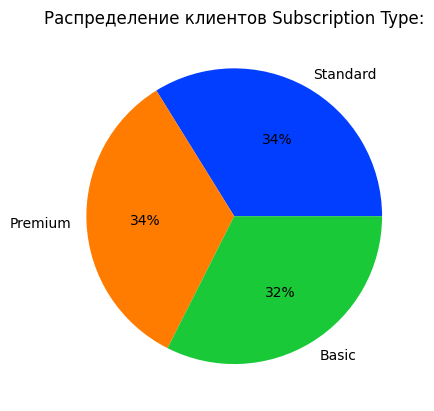

Распределение клиентов subscription type:
149128 Standard
148678 Premium
143026 Basic


In [15]:
make_piechart(df, 'Subscription Type')

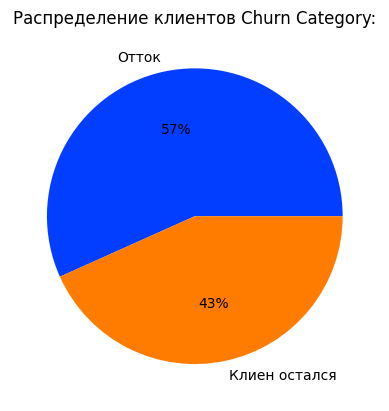

Распределение клиентов churn category:
249999 Отток
190833 Клиен остался


In [16]:
filtered = df.copy()
filtered['Churn Category'] = ['Отток' if x == 1.0 else 'Клиен остался' for x in df['Churn']]
make_piechart(filtered, 'Churn Category')

###  В наборе данных содержится больше записей об ушедших клиентах.

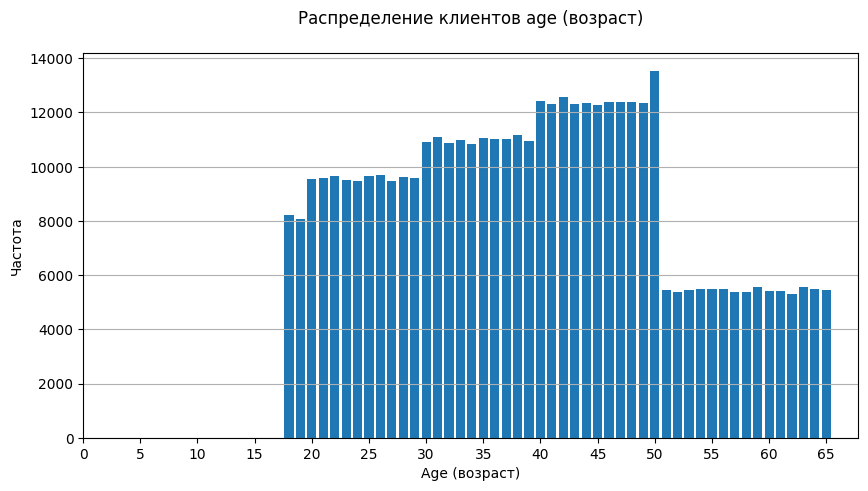

Распеределение клиентов age (возраст): 39.37 ± 39.00 возраст
Median: 39.00 возраст
Minimum: 18 возраст
Maximum: 65 возраст

0.162 Skewness



In [17]:
make_barplot(df, 'Age', custom_ticks=np.arange(0, 66, 5), additional=' (возраст)', unit='возраст')

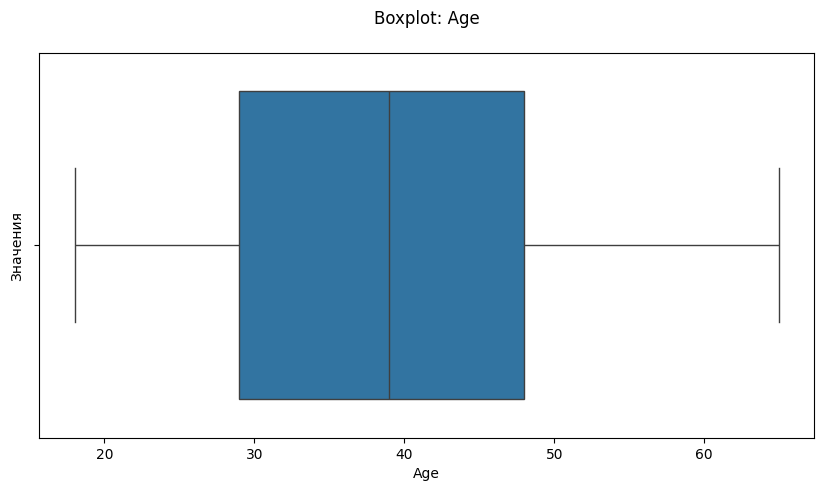

In [18]:
make_boxplot(df, 'Age')

### **Большинство клиентов — люди в возрасте 40–50 лет, причём чаще всего это люди в возрасте 50 лет. Количество клиентов в возрасте 51 года и старше крайне мало.**


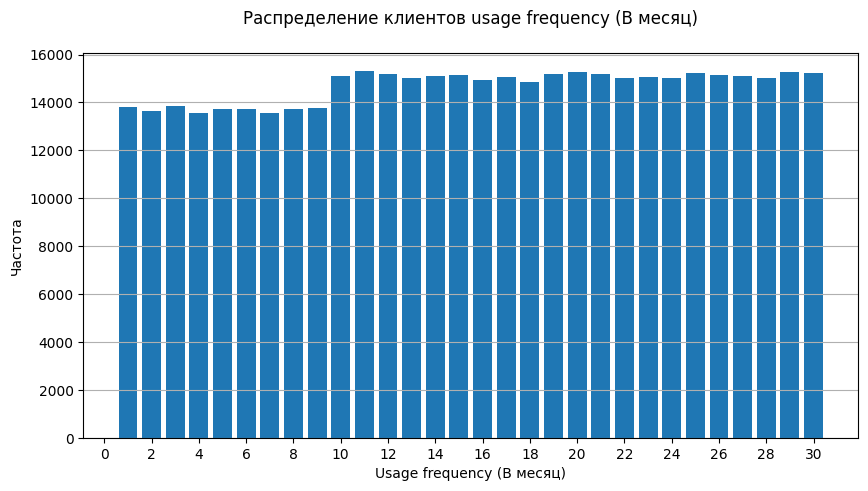

Распеределение клиентов usage frequency (В месяц): 15.81 ± 16.00 Время
Median: 16.00 Время
Minimum: 1 Время
Maximum: 30 Время

-0.043 Skewness



In [19]:
make_barplot(df, 'Usage Frequency', custom_ticks=np.arange(0, 31, 2), unit='Время', additional=' (В месяц)')

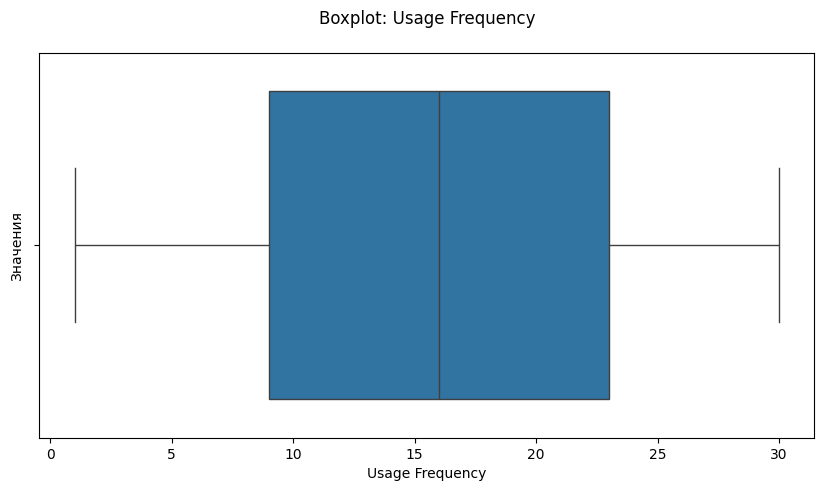

In [20]:
make_boxplot(df, 'Usage Frequency')

### **В среднем клиенты пользуются услугами компании 16 раз в месяц, при этом индивидуальная частота использования сильно разнится, что скорее всео говорит о различных привычках потребления услуг.**

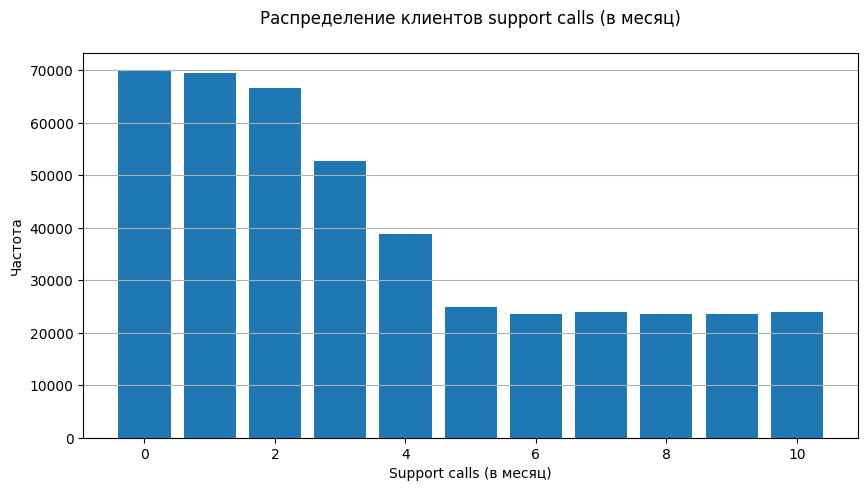

Распеределение клиентов support calls (в месяц): 3.60 ± 3.00 звонки
Median: 3.00 звонки
Minimum: 0 звонки
Maximum: 10 звонки

0.667 Skewness



In [21]:
make_barplot(df, 'Support Calls', unit='звонки', additional=' (в месяц)')

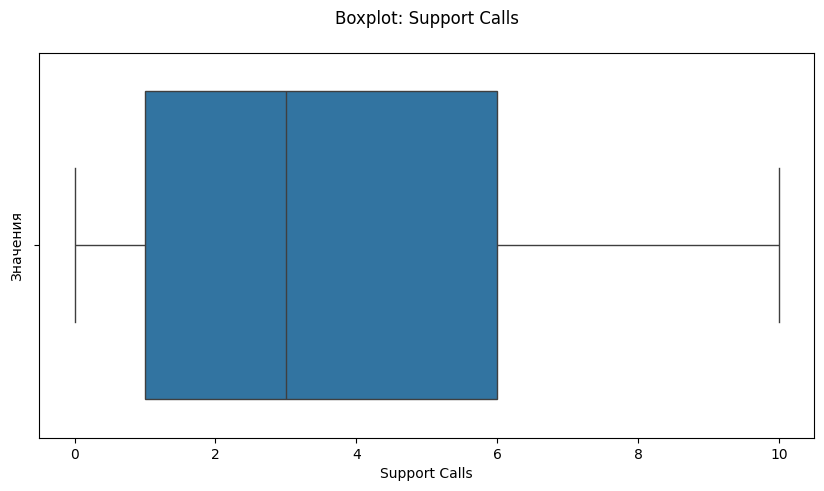

In [22]:
make_boxplot(df, 'Support Calls')

### Видим, что клиенты обращаются в тех поддержку три раза. Но в общем распеределении многие клиенты вообще не обращаются

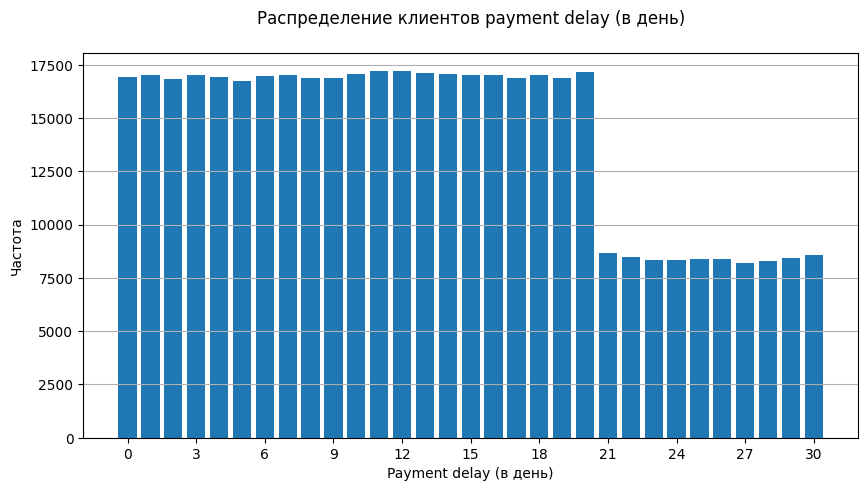

Распеределение клиентов payment delay (в день): 12.97 ± 12.00 days
Median: 12.00 days
Minimum: 0 days
Maximum: 30 days

0.267 Skewness



In [23]:
make_barplot(df, 'Payment Delay', custom_ticks=np.arange(0, 32, 3), unit='days', additional=' (в день)')

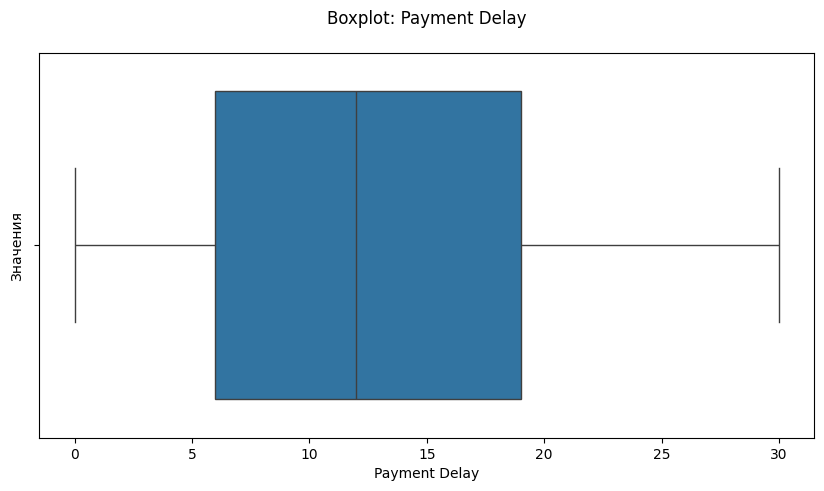

In [24]:
make_boxplot(df, 'Payment Delay')

### В среднем клиенты задерживают платежи на 13 дней. Большинство клиентов платят в течение 20 дней.

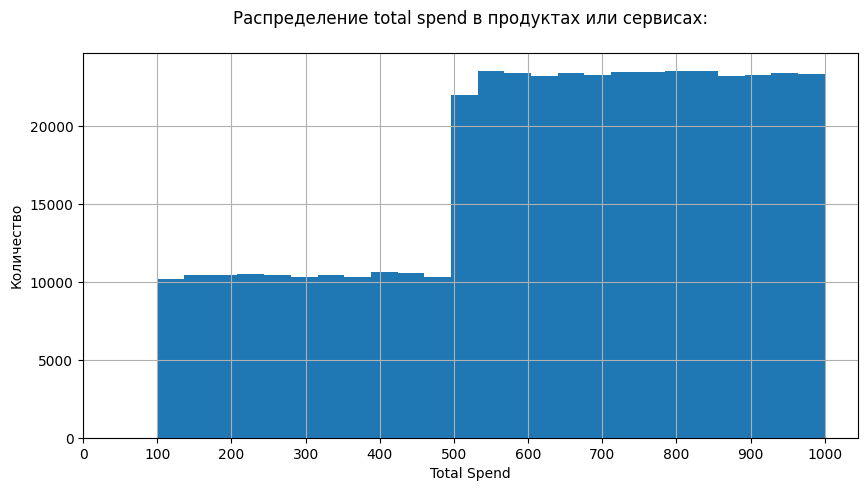

Распределение total spend в продуктах или сервисах: 631.62 ± 661.00 USD
Медиана: 661.00 USD
Минимум: 100.0 USD
Максимум: 1000.0 USD
-0.457 Ассиметрия(выброс)



In [25]:
# Рассмотрим теперь непрерывные распеределения, где большая вариабельность выходов
make_histogram(df, 'Total Spend', bins=25, custom_ticks=np.arange(0, 1001, 100), unit='USD', additional=" в продуктах или сервисах")

### В среднем клиент тратит 661$. Большинство больше 500. Если мы посмотрим на гистограмму, то ясно увидим, что разделение между клиентами, которые тратят больше и меньше, составляет около 500. Мы можем использовать это, чтобы разделить клиентов на клиентов с высокой ценностью (общая стоимость выше 500) и клиентов с низкой ценностью

In [26]:
# Перейдём к многофакторному анализу.
# Какие корелляции нам могут быть важны и интересны в плане оттока клиентов?

#Насколько пол влияет на то, уйдет клиент или нет?

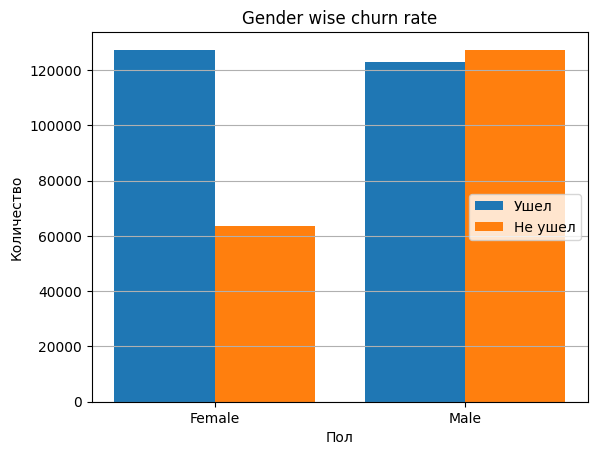

In [27]:
gender_churn = df.groupby(['Gender', 'Churn']).size().unstack()

X = list(gender_churn.index)
churn_0 = list(gender_churn.iloc[:, 0])
churn_1 = list(gender_churn.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Ушел')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Не ушел')

plt.xticks(X_axis, X)
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.title("Gender wise churn rate")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### Видим колоссальную разницу в оттоке мужчин и женщин. Это важный признак, с которым надо работать


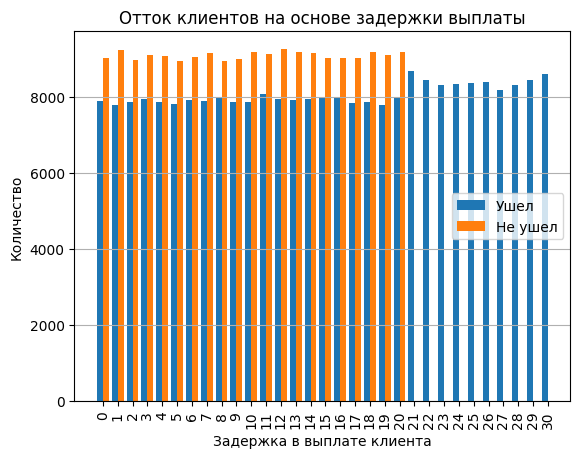

In [28]:
filtered = df.groupby(['Payment Delay', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Ушел')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Не ушел')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Задержка в выплате клиента")
plt.ylabel('Количество')
plt.title("Отток клиентов на основе задержки выплаты")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### Видно, что среди тех клиентов, у кого задержка до 20 дней, те уходят/не уходят равномерно, причем большинство всё-таки остаётся. А среди тех, у кого выплата после 20го дня, те поголовно уходят.

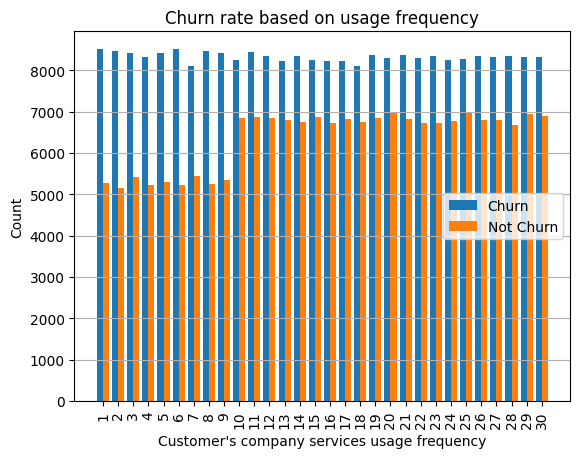

In [29]:
# Также может быть явная гипотеза - те, кто чаще пользуются сервисом - реже оттекают. Проверим:
filtered = df.groupby(['Usage Frequency', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')

plt.xticks(X_axis, X, rotation=90)
plt.xlabel("Customer's company services usage frequency")
plt.ylabel('Count')
plt.title("Churn rate based on usage frequency")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### А вот и нет. Клиенты, которые ушли, как правило, пользуются услугами компании значительно чаще, чем клиенты, которые остались.

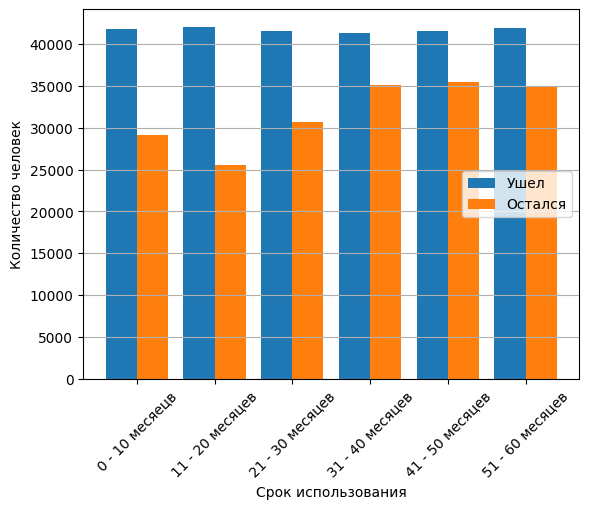

In [30]:
# Ещё одна гипотеза - реже ли уходят те клиенты, которые дольше с компанией?
def categorize_age(age):
    if 0 <= age <= 10:
        return '0 - 10 месяецв'
    elif 11 <= age <= 20:
        return '11 - 20 месяцев'
    elif 21 <= age <= 30:
        return '21 - 30 месяцев'
    elif 31 <= age <= 40:
        return '31 - 40 месяцев'
    elif 41 <= age <= 50:
        return '41 - 50 месяцев'
    elif 51 <= age <= 60:
        return '51 - 60 месяцев'
    else:
        pass # For nan values

filtered = df.copy()
filtered['tenure_segmentation'] = df['Tenure'].apply(categorize_age)
filtered = filtered.groupby(['tenure_segmentation', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Ушел')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Остался')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Срок использования')
plt.ylabel('Количество человек')
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### Клиенты стабильно уходят не смотря на срок общей работы

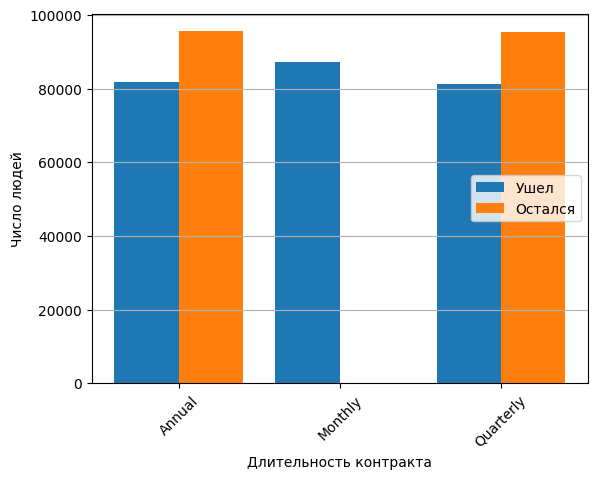

In [31]:
# Ещё гипотеза -Существует ли закономерность в сроках действия контрактов с клиентами, которые ушли?
filtered = df.groupby(['Contract Length', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Ушел')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Остался')

plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Длительность контракта')
plt.ylabel('Число людей')
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### Клиенты с квартальными контрактами демонстрируют самый низкий уровень оттока, в то время как клиенты с ежемесячными контрактами демонстрируют самый высокий уровень оттока.

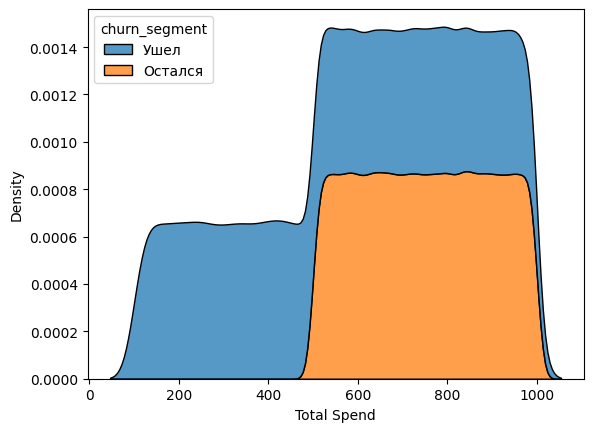

In [32]:
# И наверная самое главное - Существует ли корреляция между общими расходами и уровнем оттока?
filtered = df.copy()
filtered['churn_segment'] = ['Ушел' if x == 1.0 else 'Остался' for x in df['Churn']]

sns.kdeplot(data=filtered, x="Total Spend", hue="churn_segment", multiple="stack")
plt.show()

### Клиенты, которые уходят, как правило, тратят значительно больше денег, чем те, кто этого не делает. Как уходящие, так и не уходящие клиенты имеют схожее распределение общих расходов и общее поведение в плане расходов.

# **Перейдём к обучению**



In [82]:
y=df['Churn']
X=df.drop('Churn',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
# Выбросим индекс полученных DataFrames
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [83]:
X_train

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,29,Female,8,25,1,0,Basic,Annual,932.25,9
1,19,Male,21,16,0,17,Basic,Quarterly,635.16,10
2,53,Female,30,23,1,8,Premium,Monthly,924.00,30
3,50,Male,27,17,4,15,Standard,Annual,882.78,4
4,33,Female,25,1,2,20,Basic,Quarterly,595.45,12
...,...,...,...,...,...,...,...,...,...,...
308577,24,Female,1,4,2,18,Standard,Quarterly,740.72,15
308578,62,Male,29,23,9,24,Standard,Quarterly,327.10,11
308579,34,Male,13,16,1,6,Premium,Quarterly,520.36,23
308580,35,Male,23,18,4,10,Standard,Monthly,420.00,3


In [84]:
X_test

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,43,Male,24,27,3,10,Standard,Quarterly,658.48,8
1,41,Female,21,12,0,19,Premium,Quarterly,463.00,1
2,52,Female,31,26,6,11,Standard,Quarterly,621.00,11
3,46,Male,7,19,3,16,Standard,Annual,807.99,27
4,47,Male,26,15,0,15,Basic,Quarterly,534.91,3
...,...,...,...,...,...,...,...,...,...,...
132245,30,Male,60,30,0,13,Premium,Annual,506.93,19
132246,24,Female,36,22,0,12,Basic,Annual,753.56,13
132247,30,Male,59,21,0,9,Premium,Monthly,498.00,16
132248,30,Female,27,25,0,22,Basic,Monthly,123.63,5


### Перейдём к обработке и кодированию категориальных признаков, ведь Если в тесте есть категории, которых не было в трейне, то тот же OHE не сможет обработать тестовые данные.

In [85]:
def validate_test_data_categorical_columns(train_df, test_df):
    problem = {}
    train_cols = set(train_df.select_dtypes(include=['object', 'category']).columns)
    test_cols  = set(test_df.select_dtypes(include=['object', 'category']).columns)

    # Создадим множества и вычитаем одного из другого(дополнение множеств)
    missing_in_train = sorted(test_cols - train_cols)
    missing_in_test  = sorted(train_cols - test_cols)
    if missing_in_train or missing_in_test:
        problem['column_mismatch'] = {
            'missing_in_train': missing_in_train,
            'missing_in_test': missing_in_test
        }

    common = sorted(train_cols & test_cols)
    value_mismatch = {}
    # перебираем все значения в пересечении нащих категориальных множеств
    for col in common:
        train_vals = set(train_df[col].dropna().unique()) #берем ток уникальные и не nan
        test_vals  = set(test_df[col].dropna().unique())
        missing_in_train = sorted(test_vals - train_vals)
        missing_in_test = sorted(train_vals - test_vals)
        if missing_in_train or missing_in_test:
            value_mismatch[col] = {
                'unseen_in_train': missing_in_train,
                'missing_in_test': missing_in_test
            }

    if value_mismatch:
        problem['value_mismatch'] = value_mismatch

    return 'В трейне и тесте одинаковые категории'

validate_test_data_categorical_columns(X_train, X_test)

'В трейне и тесте одинаковые категории'

In [48]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore') #sparse_output=False - OHE возращает матрицу в numpy, что жрёт память и ресурсы, но удобно для просмотра. Иначе бы возвращало разреженую матрицу

In [86]:
train_OHE = encoder.fit_transform(X_train.select_dtypes(include=['object', 'category'])) #обучили на трейн
test_OHE = encoder.transform(X_test.select_dtypes(include=['object', 'category']))

In [87]:
train_OHE

array([[1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [88]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

In [89]:
# Восстанавливаем имена и индексы
ohe_cols = encoder.get_feature_names_out(cat_cols)
train_OHE = pd.DataFrame(train_OHE, columns=ohe_cols, index=X_train.index)
test_OHE  = pd.DataFrame(test_OHE,  columns=ohe_cols, index=X_test.index)

In [90]:
X_train = pd.concat([X_train.drop(columns=cat_cols), train_OHE], axis=1)
X_test  = pd.concat([X_test.drop(columns=cat_cols),  test_OHE],  axis=1)

In [91]:
X_train

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,29,8,25,1,0,932.25,9,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,19,21,16,0,17,635.16,10,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,53,30,23,1,8,924.00,30,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,50,27,17,4,15,882.78,4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,33,25,1,2,20,595.45,12,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308577,24,1,4,2,18,740.72,15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
308578,62,29,23,9,24,327.10,11,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
308579,34,13,16,1,6,520.36,23,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
308580,35,23,18,4,10,420.00,3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [92]:
X_test

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,43,24,27,3,10,658.48,8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,41,21,12,0,19,463.00,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,52,31,26,6,11,621.00,11,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,46,7,19,3,16,807.99,27,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,47,26,15,0,15,534.91,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132245,30,60,30,0,13,506.93,19,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
132246,24,36,22,0,12,753.56,13,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
132247,30,59,21,0,9,498.00,16,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
132248,30,27,25,0,22,123.63,5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Бейслайн модели

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def metrics(y_true, y_pred):
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.3f}")
    print()
    print("Confusion Matrix:") # матрица ошибок TP,TN и тд
    print(confusion_matrix(y_true, y_pred))


In [94]:
from sklearn.model_selection import StratifiedKFold, cross_validate

def kfold_scores(estimator, X, y, k_folds=5, random_state=42):
    print(f"Запускаю {k_folds}-кратную кросс-валидацию...")
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_state)

    # Считаем сразу несколько метрик за один проход
    scores = cross_validate(
        estimator, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall'], n_jobs=-1
    )

    acc_mean, acc_std = scores['test_accuracy'].mean(), scores['test_accuracy'].std()
    prec_mean, prec_std = scores['test_precision'].mean(), scores['test_precision'].std()
    rec_mean, rec_std = scores['test_recall'].mean(), scores['test_recall'].std()

    print("Средние метрики по фолдам:")
    print(f"— Accuracy:  {acc_mean:.3f} ± {acc_std:.3f}")
    print(f"— Precision: {prec_mean:.3f} ± {prec_std:.3f}")
    print(f"— Recall:    {rec_mean:.3f} ± {rec_std:.3f}")


## Начнём обучать и найдём лучшую модельку

In [95]:
import time
model = LogisticRegression()
start = time.perf_counter()
kfold_scores(model, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")

Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  0.871 ± 0.012
— Precision: 0.897 ± 0.011
— Recall:    0.872 ± 0.011
Время кросс-валидации: 9.879 с


In [63]:
from sklearn.naive_bayes import GaussianNB
import time
model = GaussianNB()
start = time.perf_counter()
kfold_scores(model, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")


#причем обучилось значительно быстрее, чем на логист регрессии

Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  0.865 ± 0.001
— Precision: 1.000 ± 0.000
— Recall:    0.762 ± 0.001
Время кросс-валидации: 0.830 с


In [72]:

import time
model =  KNeighborsClassifier()
start = time.perf_counter()
kfold_scores(model, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")

Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  0.890 ± 0.002
— Precision: 0.974 ± 0.001
— Recall:    0.827 ± 0.002
Время кросс-валидации: 33.745 с


In [97]:
from sklearn.tree import DecisionTreeClassifier
import time
model2 = DecisionTreeClassifier(random_state=23)
start = time.perf_counter()
kfold_scores(model2, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")


Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  1.000 ± 0.000
— Precision: 1.000 ± 0.000
— Recall:    1.000 ± 0.000
Время кросс-валидации: 4.160 с


In [78]:
import time
model = RandomForestClassifier(random_state=42)
start = time.perf_counter()
kfold_scores(model, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")

Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  0.999 ± 0.000
— Precision: 1.000 ± 0.000
— Recall:    0.998 ± 0.000
Время кросс-валидации: 98.227 с


In [77]:
import xgboost as xgb
import time
model = xgb.XGBClassifier(random_state=42)
start = time.perf_counter()
kfold_scores(model, X_train, y_train)
elapsed = time.perf_counter() - start
print(f"Время кросс-валидации: {elapsed:.3f} с")


Запускаю 5-кратную кросс-валидацию...
Средние метрики по фолдам:
— Accuracy:  1.000 ± 0.000
— Precision: 1.000 ± 0.000
— Recall:    1.000 ± 0.000
Время кросс-валидации: 16.947 с


## Результаты интересные... Будем очев обучать на бустинге и дереве решений

In [103]:
#Перемешали целевые метки, чтобы понять - нет ли утечки, а то слишком хорошие метрикиВ
def sanity_check_shuffle_labels(X, y, k=5):
    y_shuf = y.sample(frac=1.0, random_state=123).reset_index(drop=True)
    X_shuf = X.reset_index(drop=True)
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_validate(DecisionTreeClassifier(random_state=42),
                            X_shuf, y_shuf, cv=cv,
                            scoring=['accuracy','precision','recall'])
    print("Sanity-check (перемешанные метки):")
    for m in ['accuracy','precision','recall']:
        vals = scores[f'test_{m}']
        print(f"{m}: {vals.mean():.3f} ± {vals.std():.3f}")


In [104]:
sanity_check_shuffle_labels(X_train, y_train)
#получилось близко к случайности, нет учтечки

Sanity-check (перемешанные метки):
accuracy: 0.508 ± 0.001
precision: 0.567 ± 0.001
recall: 0.559 ± 0.002


In [76]:
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [99]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [100]:
y_pred = decision_tree_classifier.predict(X_test)

metrics(y_test, y_pred)

Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000

Confusion Matrix:
[[56969     3]
 [    8 75270]]


In [102]:
y_pred = xgb_classifier.predict(X_test)
metrics(y_test, y_pred)

Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1-score:  1.000

Confusion Matrix:
[[56969     3]
 [   18 75260]]
